In [6]:
import pandas as pd
import spacy
import benepar
from tqdm import tqdm
import utils  # Assumes your utils.py file is in the same directory

tqdm.pandas()

def load_and_standardize_anaphoric(filepath='Anaphoric.csv'):
    """Loads and standardizes the original Anaphoric.csv dataset."""
    df = pd.read_csv(filepath)
    # Use the correct column for requirements
    requirements_column = 'Raw Requirements'
    if requirements_column not in df.columns:
        requirements_column = df.columns[0]
    
    # Select and rename columns to a standard format
    df = df[[requirements_column, 'Manual Evaluation']].copy()
    df.rename(columns={
        requirements_column: 'context',
        'Manual Evaluation': 'manual_label'
    }, inplace=True)
    
    print(f"Loaded {len(df)} samples from {filepath}")
    return df

def load_and_standardize_reqeval(filepath='ReqEval.csv'):
    """
    Loads and standardizes the NEW version of ReqEval.csv.
    This function now uses the 'DetectedAs' column directly.
    """
    df = pd.read_csv(filepath)
    
    # Handle potential Byte Order Mark (BOM) in the first column name
    id_col = df.columns[0]
    if 'ID' in id_col:
        df.rename(columns={id_col: 'ID'}, inplace=True)

    # Select and rename columns to a standard format
    df = df[['Context(cj)', 'DetectedAs']].copy()
    df.rename(columns={
        'Context(cj)': 'context',
        'DetectedAs': 'manual_label'
    }, inplace=True)
    
    # Standardize labels: 'UNAMBIGUOUS' becomes 'UA', 'AMBIGUOUS' becomes 'A'
    df['manual_label'] = df['manual_label'].apply(
        lambda x: 'UA' if x.strip() == 'UNAMBIGUOUS' else 'A'
    )
    
    print(f"Loaded {len(df)} samples from {filepath}")
    return df


def main():
    """
    Main function to load, combine, and preprocess all datasets.
    """
    # --- Part 1: Load and Combine All Datasets ---
    df_anaphoric = load_and_standardize_anaphoric()
    df_reqeval = load_and_standardize_reqeval()
    
    # Combine all standardized dataframes
    combined_df = pd.concat([df_anaphoric, df_reqeval], ignore_index=True)
    
    # Drop rows with missing context and remove duplicates to process each unique requirement once
    combined_df.dropna(subset=['context'], inplace=True)
    combined_df.drop_duplicates(subset=['context'], inplace=True, keep='first')
    combined_df.reset_index(drop=True, inplace=True)
    
    print(f"\\nCombined dataset shape after cleaning: {combined_df.shape}")

    # --- Part 2: Replicate Processing from setup_preprocessing.ipynb ---
    # This part is the same logic as your notebook, but applied to the combined data.

    print("\\nLoading NLP models...")
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe('benepar', config={'model': 'benepar_en3'})
    
    print("Applying NLP pipeline to all requirements...")
    combined_df['Context_doc'] = combined_df['context'].progress_apply(lambda text: utils.applynlp(text, nlp))
    
    pronouns_list = [
        "i", "me", "my", "mine", "myself", "you", "your", "yours", "yourself",
        "he", "him", "his", "himself", "she", "her", "hers", "herself",
        "it", "its", "itself", "we", "us", "our", "ours", "ourselves",
        "they", "them", "their", "theirs", "themselves"
    ]
    
    processed_triples = []
    ids_used = set()
    
    print("Generating (Pronoun, Candidate Antecedent) pairs...")
    for i, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0], desc="Generating Triples"):
        doc = row['Context_doc']
        
        if not isinstance(doc, spacy.tokens.Doc):
            continue

        pronouns_in_doc = utils.findPronouns(doc, pronouns_list)
        
        for j, pronoun in enumerate(pronouns_in_doc):
            base_id = f"{i}-{pronoun.text.lower()}-{j}"
            
            k = 0
            pronoun_id = base_id
            while pronoun_id in ids_used:
                k += 1
                pronoun_id = f"{base_id}-{k}"
            ids_used.add(pronoun_id)
            
            candidate_antecedents = utils.getNPs(doc, pronoun)
            
            for candidate in candidate_antecedents:
                processed_triples.append([
                    pronoun_id,
                    doc,
                    pronoun,
                    pronoun.i,
                    candidate,
                    row['manual_label'] # Use the standardized label
                ])

    triples_df = pd.DataFrame(processed_triples, columns=[
        "Id", "Context", "Pronoun", "Position", 
        "Candidate_Antecedent", "Manual Evaluation"
    ])

    print(f"\\nGenerated {len(triples_df)} pronoun-antecedent pairs from all sources.")

    # --- Part 3: Finalize and Save for SpanBERT ---
    print("Finalizing DataFrame: Creating Hashed Context and serializing data...")
    final_df = triples_df.copy()
    hashed_context_map = {}

    for pronoun_id, group in final_df.groupby('Id'):
        first_row = group.iloc[0]
        pronoun_token = first_row['Pronoun']
        context_doc = first_row['Context']
        
        hashed_pronoun = f"{pronoun_token.text}#{pronoun_id.split('-')[-1]}"
        
        hashed_context_map[pronoun_id] = (
            context_doc[:pronoun_token.i].text_with_ws + 
            hashed_pronoun + 
            context_doc[pronoun_token.i + 1:].text_with_ws
        )
    
    final_df['Hashed_Context'] = final_df['Id'].map(hashed_context_map)
    
    final_df['Pronoun'] = final_df['Pronoun'].apply(lambda token: token.text)
    final_df['Candidate_Antecedent'] = final_df['Candidate_Antecedent'].apply(lambda span: span.text)
    
    final_df.drop(columns=['Context'], inplace=True)
    
    final_df = final_df[[
        'Id', 'Hashed_Context', 'Pronoun', 'Position', 
        'Candidate_Antecedent', 'Manual Evaluation'
    ]]
    
    output_filename = 'anaphoric_ambiguity_spanbert_input.csv'
    final_df.to_csv(output_filename, index=False)
    
    print(f"\\nPreprocessing complete. Data ready for SpanBERT and saved to '{output_filename}'")
    print(f"Final combined dataset has {len(final_df)} rows.")

if __name__ == '__main__':
    main()

Loaded 159 samples from Anaphoric.csv
Loaded 109 samples from ReqEval.csv
\nCombined dataset shape after cleaning: (257, 2)
\nLoading NLP models...
Applying NLP pipeline to all requirements...


100%|██████████| 257/257 [00:11<00:00, 22.51it/s]


Generating (Pronoun, Candidate Antecedent) pairs...


Generating Triples: 100%|██████████| 257/257 [00:00<00:00, 17719.89it/s]

\nGenerated 827 pronoun-antecedent pairs from all sources.
Finalizing DataFrame: Creating Hashed Context and serializing data...
\nPreprocessing complete. Data ready for SpanBERT and saved to 'anaphoric_ambiguity_spanbert_input.csv'
Final combined dataset has 827 rows.


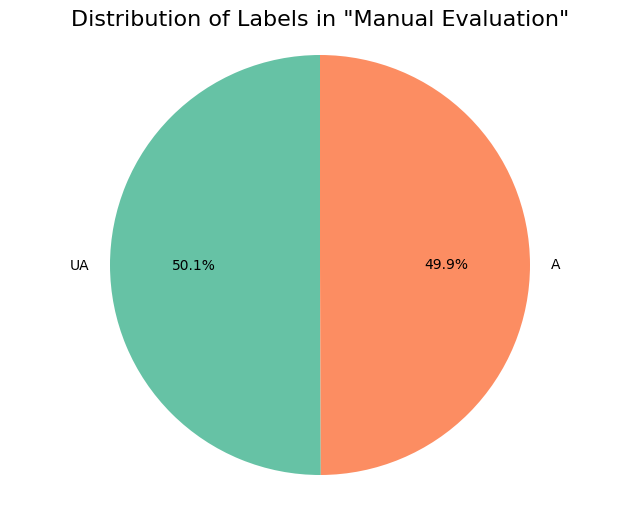

Total Manual Evaluation = UA: 414
Total Manual Evaluation = A: 413


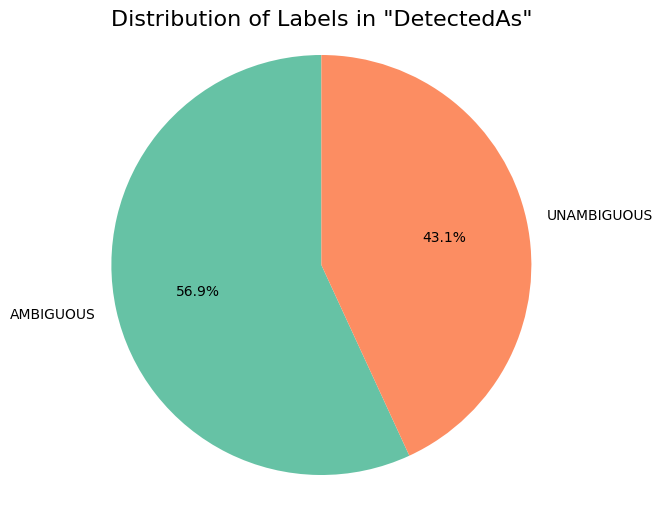

Total DetectedAs = AMBIGUOUS: 62
Total DetectedAs = UNAMBIGUOUS: 47


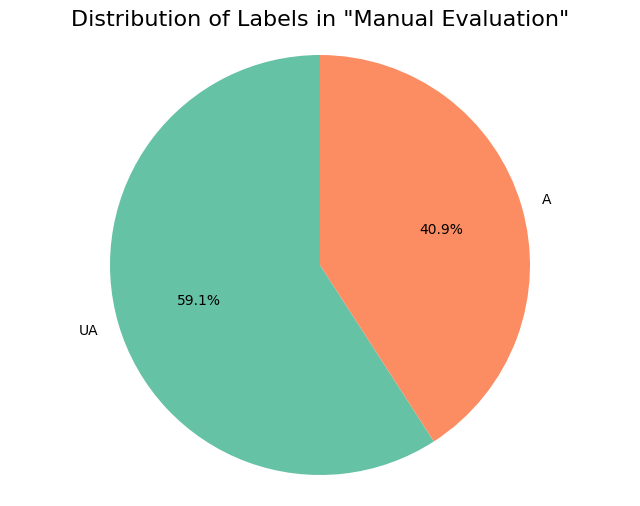

Total Manual Evaluation = UA: 94
Total Manual Evaluation = A: 65


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

anaphoric = pd.read_csv('Anaphoric.csv')
reqEval = pd.read_csv('ReqEval.csv')
final_df = pd.read_csv('anaphoric_ambiguity_spanbert_input.csv')
# Display the distribution of the target variable
def plot_label_distribution(dataset, column):
    label_counts = dataset[column].value_counts()

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
    plt.title(f'Distribution of Labels in "{column}"', fontsize=16)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    # Print total counts for each label
    for label, count in label_counts.items():
        print(f"Total {column} = {label}: {count}")
plot_label_distribution(final_df, 'Manual Evaluation')
plot_label_distribution(reqEval, 'DetectedAs')
plot_label_distribution(anaphoric, 'Manual Evaluation')